In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np
import math
from sklearn.metrics import precision_recall_curve, average_precision_score
from transformers import BertModel

### Loading Dataset

In [2]:
df_1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df_2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df_3 = pd.read_csv("data/full_dataset/goemotions_3.csv")

Displaying first 5 rows from each dataset

In [3]:
df_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_2.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,1.547529e+09,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,1.546482e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,1.548800e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,1.547497e+09,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_3.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,1.547255e+09,36,False,0,...,0,0,0,0,0,0,0,0,0,0


Concanetating All Dataset into Singel DataFrame

In [6]:
df = pd.concat([df_1, df_2, df_3])
df.shape

(211225, 37)

Checking if the dataset contains NULL values or not

In [7]:
df.isnull().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64

```The dataset does not contain any NULL values```

Checking if there is DUPLICATED data in the DataFrame

In [8]:
df.duplicated().sum()

np.int64(0)

```The dataset does not contain any DUPLICATED values```

DataFrame Information

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 71224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

### Aggregating Rater Responses
The raw dataset contains multiple entries for the same Reddit comment because each comment was reviewed by multiple independent raters.

In this step, the data is being grouped by unique ID and Text.

In [10]:
id_counts = df['id'].value_counts()
print(id_counts.unique())
print("The comments were reviewed by up to 5 different people")

[5 4 3 2 1]
The comments were reviewed by up to 5 different people


In [11]:
emotion_columns = df.columns[9:]
emotion_columns

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [12]:
grouped_df = df.groupby(['id', 'text'])[emotion_columns].sum().reset_index()
grouped_df.shape

(58011, 30)

In [13]:
grouped_df.head()

,id,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eczb527,So much time saved. Not.,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,eczb6r7,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,2


### Converting to Binary Labels
Converting the sums after grouping to binary values.

In [14]:
aggregated_df = grouped_df.copy()
for col in emotion_columns:
    aggregated_df[col] = (aggregated_df[col] > 0).astype(int)

In [15]:
aggregated_df.head()

,id,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eczb527,So much time saved. Not.,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,eczb6r7,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [16]:
unwanted_cols = ['id']

In [17]:
master_df = aggregated_df.drop(columns=unwanted_cols)

In [18]:
master_df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,So much time saved. Not.,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [19]:
master_df.shape

(58011, 29)

In [20]:
master_emotions_df = master_df[master_df['neutral']==0].copy()

In [21]:
master_emotions_df = master_emotions_df.drop(columns=['neutral'])

### Feature and Label Extraction
Defining Text/Documents as X(Feature) and Emotions as Y(Labels)

In [22]:
X = master_emotions_df['text']

In [23]:
X.head()

0    Fast as [NAME] will carry me. Seriously uptown...
2    TL;DR No more Superbowls for [NAME]. Get ready...
3                             So much time saved. Not.
6    Thanks for the advice man ! Have a great New Y...
8    Glad to hear it. You deserve your best life wi...
Name: text, dtype: object

In [24]:
y = master_emotions_df.iloc[:,1:]

In [25]:
y.head()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [26]:
cols_num_rows = y.sum(axis=0).sort_values(ascending = False)

Text(0.5, 1.0, 'Emotion Categories x No. of Samples')

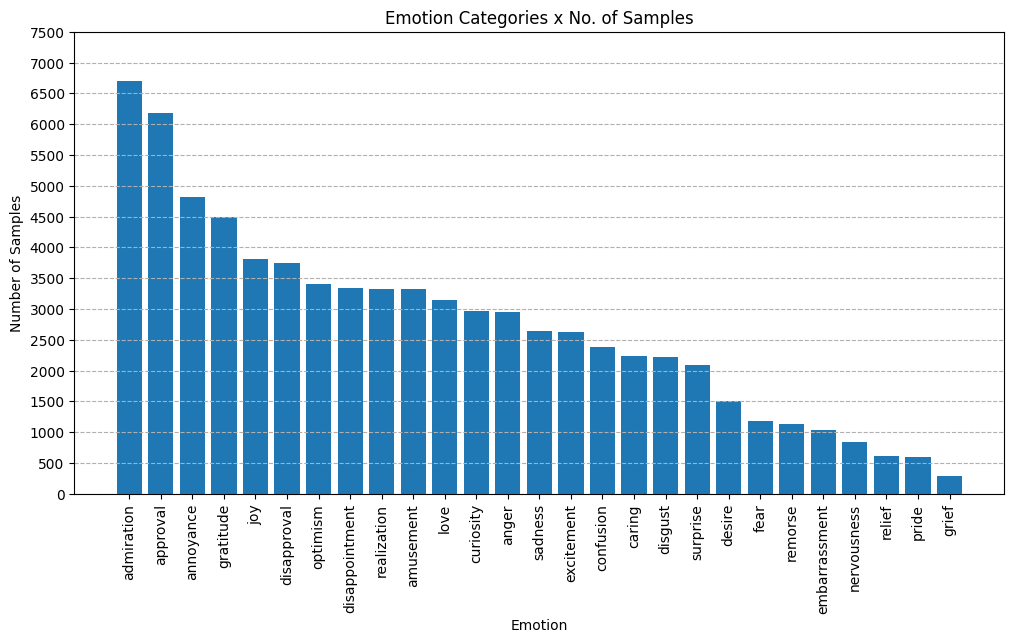

In [27]:
plt.figure(figsize=(12, 6))
plt.bar(cols_num_rows.index, cols_num_rows.values)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 8000, 500))
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--')
plt.title("Emotion Categories x No. of Samples")

### Text Preprocessing

Normalizing texts:
- lowercase the text
- remove bracket bounded words[NAME], [RELIGION]
- remove technical pronounciation, except: '!', '?'
- remove URL
- remove whitespaces

In [28]:
def clean_text(text):
    # lowercase text
    text = text.lower()
    # remove text that are inside brackets eg: [NAME], [RELIGION]
    text = re.sub(r'\[.*?\]', '', text)
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove technical punctuation characters like ""#$%&\'()*+,-./:;<=>@\\^_`{|}~"
    technical_punct = '"#$%&\'()*+,-./:;<=>@\\^_`{|}~'
    text = text.translate(str.maketrans(technical_punct, ' ' * len(technical_punct)))
    # remove white spaces
    text = " ".join(text.split())
    return text

In [29]:
X = X.apply(clean_text)

In [30]:
X.head()

0    fast as will carry me seriously uptown to down...
2    tl dr no more superbowls for get ready for ano...
3                               so much time saved not
6    thanks for the advice man ! have a great new y...
8    glad to hear it you deserve your best life wit...
Name: text, dtype: object

### Spliting Dataset
Spliting data set into 70% for training and 15% each for Cross Validation and Testing

In [31]:
type(X), type(y)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [32]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [34]:
print(f"Training samples  : {len(X_train)}")  
print(f"Validation samples: {len(X_val)}")     
print(f"Test samples      : {len(X_test)}")

Training samples  : 18541
Validation samples: 3974
Test samples      : 3973


### Tokenization and Vectorization
For tokenization, BERT Tokenizer is used. 

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [36]:
def tokenize_data(texts, max_length=64):
    return tokenizer(texts.tolist(), 
                     add_special_tokens=True, 
                     max_length=max_length, 
                     padding='max_length', 
                     truncation=True, 
                     return_attention_mask=True, 
                     return_tensors='pt')

In [37]:
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)

In [38]:
train_encodings['input_ids']

tensor([[ 101, 2010, 2767,  ...,    0,    0,    0],
        [ 101, 6919, 2135,  ...,    0,    0,    0],
        [ 101, 2572, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 3720,  ...,    0,    0,    0],
        [ 101, 2053, 3066,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ...,    0,    0,    0]])

In [39]:
train_encodings['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [40]:
X_train_ids = train_encodings['input_ids']
X_train_mask = train_encodings['attention_mask']

X_val_ids = val_encodings['input_ids']
X_val_mask = val_encodings['attention_mask']

X_test_ids = test_encodings['input_ids']
X_test_mask = test_encodings['attention_mask']

In [41]:
X_train_ids.shape, X_train_mask.shape

(torch.Size([18541, 64]), torch.Size([18541, 64]))

### Converting to pytorch tensors and loading to TensorDataset

In [42]:
y_train_tensor = torch.tensor(y_train.values).float()
y_val_tensor = torch.tensor(y_val.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [43]:
y_train_tensor.shape

torch.Size([18541, 27])

In [44]:
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val_tensor)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test_tensor)

In [45]:
train_dataset[0]

(tensor([ 101, 2010, 2767, 2001, 7916, 2004, 3109,  100,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [46]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader= DataLoader(test_dataset, batch_size=batch_size)

### Defining LSTM Model

In [47]:
class GoEmotionLSTM(nn.Module):
    def __init__(self, vocab_size = 30522, embedding_dim = 128, hidden_dim = 256, output_dim=27):
        super(GoEmotionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True, 
                            dropout=0.4, num_layers = 2)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded)
        
        # Concatenate final forward and backward hidden states
        out = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        
        # Apply dropout to the concatenated vector before the classifier
        out = self.dropout(out) 
        
        return self.fc(out)
    
    # def forward(self, x):
    #     embedded = self.embedding(x)
    #     lstm_out, (h_n, c_n) = self.lstm(embedded)
    #     last_hidden = h_n.squeeze(0)
    #     logits = self.fc(last_hidden) 
    #     return logits

Selecting device to run model

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [49]:
model = GoEmotionLSTM(vocab_size=30522, embedding_dim=128, hidden_dim=256, output_dim=27).to(device)

In [50]:
weights = torch.ones([27]) * 2.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [51]:
def plot_result(train_loss, val_loss):
    epochs_range = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, train_loss, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
    
    plt.title("Loss vs Epochs Graph")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

def plot_pr_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_probs.ravel())
    avg_precision = average_precision_score(y_true, y_probs, average="micro")

    plt.figure(figsize=(7, 5))
    plt.step(recall, precision, where='post', color='green', label=f'Micro-avg AP = {avg_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='green')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Multi-label)')
    plt.legend()
    plt.grid(True)
    plt.show()

### Training Bi-LSTM Model

Epoch [1/20]
Train Loss: 0.5014 | Val Loss: 0.4579
Val Macro F1: 0.0544
Best model saved.
Epoch [2/20]
Train Loss: 0.4473 | Val Loss: 0.4179
Val Macro F1: 0.1644
Best model saved.
Epoch [3/20]
Train Loss: 0.4173 | Val Loss: 0.3993
Val Macro F1: 0.2317
Best model saved.
Epoch [4/20]
Train Loss: 0.4013 | Val Loss: 0.3896
Val Macro F1: 0.2620
Best model saved.
Epoch [5/20]
Train Loss: 0.3896 | Val Loss: 0.3883
Val Macro F1: 0.2783
Best model saved.
Epoch [6/20]
Train Loss: 0.3798 | Val Loss: 0.3775
Val Macro F1: 0.3290
Best model saved.
Epoch [7/20]
Train Loss: 0.3717 | Val Loss: 0.3731
Val Macro F1: 0.3280
Epoch [8/20]
Train Loss: 0.3634 | Val Loss: 0.3678
Val Macro F1: 0.3427
Best model saved.
Epoch [9/20]
Train Loss: 0.3574 | Val Loss: 0.3710
Val Macro F1: 0.3426
Epoch [10/20]
Train Loss: 0.3509 | Val Loss: 0.3642
Val Macro F1: 0.3638
Best model saved.
Epoch [11/20]
Train Loss: 0.3460 | Val Loss: 0.3656
Val Macro F1: 0.3637
Epoch [12/20]
Train Loss: 0.3405 | Val Loss: 0.3631
Val Macro 

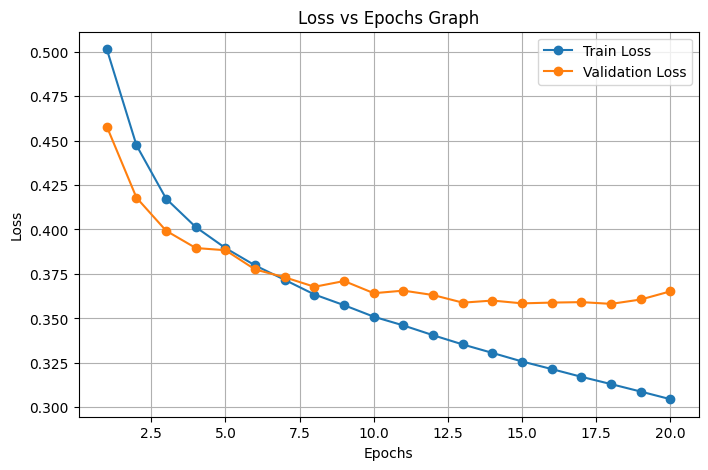

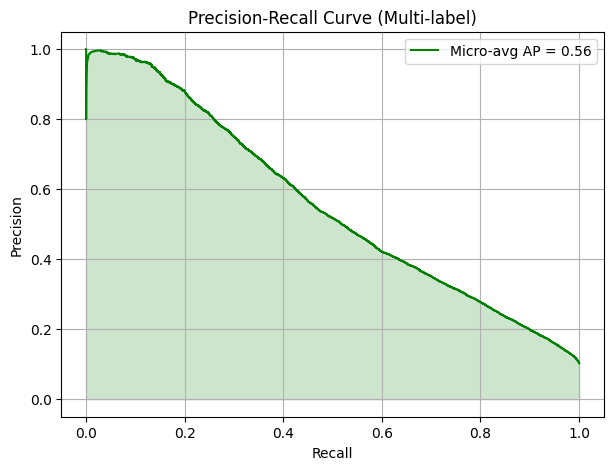

In [52]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()

    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_lstm_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)

### Defining Seq2Seq Model

In [53]:
class GoEmotionSeq2Seq(nn.Module):
    def __init__(self, vocab_size = 30522, embedding_dim = 128, hidden_dim = 256, output_dim=27):
        super(GoEmotionSeq2Seq, self).__init__()
        # BERT Embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Encoder with 3-layer Bi-LSTM
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True, 
                            dropout=0.4, num_layers = 2)
        # Context vectors from encoder layer
        self.context_vector = hidden_dim*2
        # Decoder
        self.decoder = nn.LSTM(self.context_vector, self.context_vector, batch_first= True)
        
        self.fc = nn.Linear(self.context_vector, output_dim)
        self.dropout=nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)

        # Outputs of the Encoder
        _, (hidden_state, cell_state) = self.encoder(embedded)

        # Last Cell and Hidden States as Context Vectors 
        hs_forward = hidden_state[-2, :, :]
        hs_backward = hidden_state[-1, :, :]
        cs_forward = cell_state[-2, :, :]
        cs_backward = cell_state[-1, :, :]

        # Concatenation Hidden States and Cell States for Decoder 
        context_hs = torch.cat((hs_forward, hs_backward), dim=1).unsqueeze(1)
        context_cs = torch.cat((cs_forward, cs_backward), dim=1).unsqueeze(1)

        # Output from Decoder
        decoder_out, _ = self.decoder(context_hs, (context_hs.transpose(0,1), context_cs.transpose(0,1)))
        logits = self.fc(self.dropout(decoder_out.squeeze(1)))
        return logits

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [55]:
model = GoEmotionSeq2Seq().to(device)

In [56]:
weights = torch.ones([27]) * 2.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Epoch [1/20]
Train Loss: 0.5005 | Val Loss: 0.4599
Val Macro F1: 0.0580
Best model saved.
Epoch [2/20]
Train Loss: 0.4478 | Val Loss: 0.4223
Val Macro F1: 0.1737
Best model saved.
Epoch [3/20]
Train Loss: 0.4172 | Val Loss: 0.4000
Val Macro F1: 0.2379
Best model saved.
Epoch [4/20]
Train Loss: 0.3976 | Val Loss: 0.3901
Val Macro F1: 0.2756
Best model saved.
Epoch [5/20]
Train Loss: 0.3840 | Val Loss: 0.3787
Val Macro F1: 0.3109
Best model saved.
Epoch [6/20]
Train Loss: 0.3731 | Val Loss: 0.3733
Val Macro F1: 0.3274
Best model saved.
Epoch [7/20]
Train Loss: 0.3636 | Val Loss: 0.3708
Val Macro F1: 0.3487
Best model saved.
Epoch [8/20]
Train Loss: 0.3560 | Val Loss: 0.3681
Val Macro F1: 0.3566
Best model saved.
Epoch [9/20]
Train Loss: 0.3486 | Val Loss: 0.3639
Val Macro F1: 0.3647
Best model saved.
Epoch [10/20]
Train Loss: 0.3425 | Val Loss: 0.3639
Val Macro F1: 0.3660
Best model saved.
Epoch [11/20]
Train Loss: 0.3369 | Val Loss: 0.3641
Val Macro F1: 0.3700
Best model saved.
Epoch [1

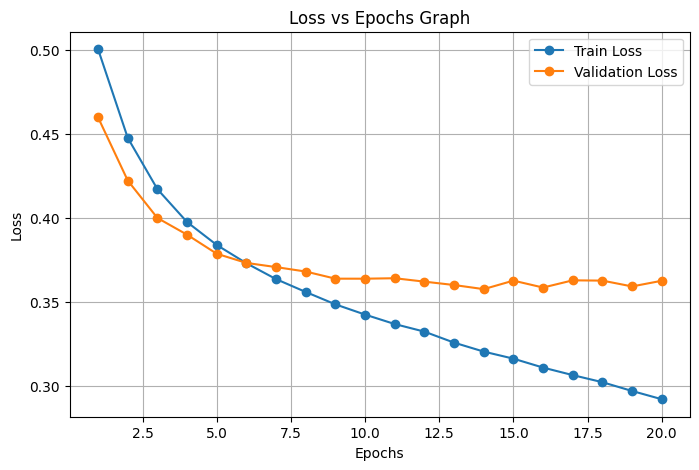

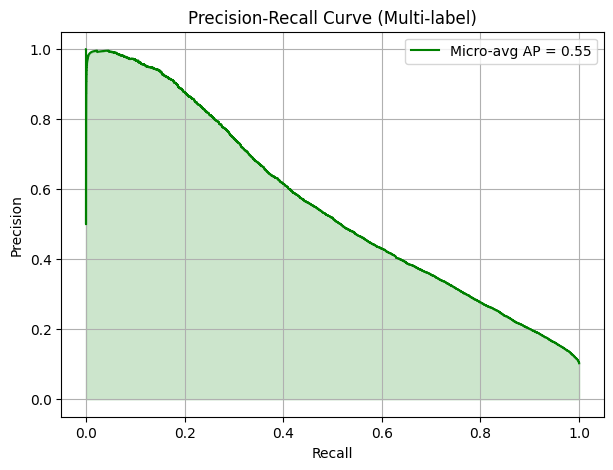

In [57]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()
    
    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_seq2seq_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)

### Transformer Model

In [58]:
class GoEmotionTransformer(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=128, n_heads=8, n_layers=3, output_dim=27, max_len=64):
        super(GoEmotionTransformer, self).__init__()
        
        # 1. Token & Positional Embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        
        # 2. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dim_feedforward=embed_dim * 4, 
            dropout=0.1, 
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 3. Classification Head
        self.dropout = nn.Dropout(0.3)
        self.pre_classifier = nn.Linear(embed_dim, embed_dim)
        self.classifier = nn.Linear(embed_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len]
        batch_size, seq_len = x.size()
        
        # Add embeddings and positions
        embeddings = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        
        # Pass through Transformer layers
        hidden_states = self.transformer_encoder(embeddings, src_key_padding_mask=mask)
        
        # 4. BERT-style Pooling
        pooled_output = hidden_states[:, 0, :] 
        
        # Additional dense layer before output 
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = self.relu(pooled_output)
        
        # Final Logits
        logits = self.classifier(self.dropout(pooled_output))
        return logits

In [59]:
model = GoEmotionTransformer(vocab_size=30522, embed_dim=128, n_heads=8, n_layers=3, output_dim=27, max_len=64).to(device)

weights = torch.ones([27]) * 2.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Epoch [1/20]
Train Loss: 0.5135 | Val Loss: 0.4517
Val Macro F1: 0.0680
Best model saved.
Epoch [2/20]
Train Loss: 0.4376 | Val Loss: 0.4018
Val Macro F1: 0.2388
Best model saved.
Epoch [3/20]
Train Loss: 0.4047 | Val Loss: 0.3800
Val Macro F1: 0.2968
Best model saved.
Epoch [4/20]
Train Loss: 0.3853 | Val Loss: 0.3690
Val Macro F1: 0.3437
Best model saved.
Epoch [5/20]
Train Loss: 0.3737 | Val Loss: 0.3647
Val Macro F1: 0.3575
Best model saved.
Epoch [6/20]
Train Loss: 0.3659 | Val Loss: 0.3581
Val Macro F1: 0.3598
Best model saved.
Epoch [7/20]
Train Loss: 0.3583 | Val Loss: 0.3554
Val Macro F1: 0.3701
Best model saved.
Epoch [8/20]
Train Loss: 0.3525 | Val Loss: 0.3531
Val Macro F1: 0.3860
Best model saved.
Epoch [9/20]
Train Loss: 0.3470 | Val Loss: 0.3516
Val Macro F1: 0.3884
Best model saved.
Epoch [10/20]
Train Loss: 0.3419 | Val Loss: 0.3495
Val Macro F1: 0.4034
Best model saved.
Epoch [11/20]
Train Loss: 0.3374 | Val Loss: 0.3476
Val Macro F1: 0.4018
Epoch [12/20]
Train Loss: 

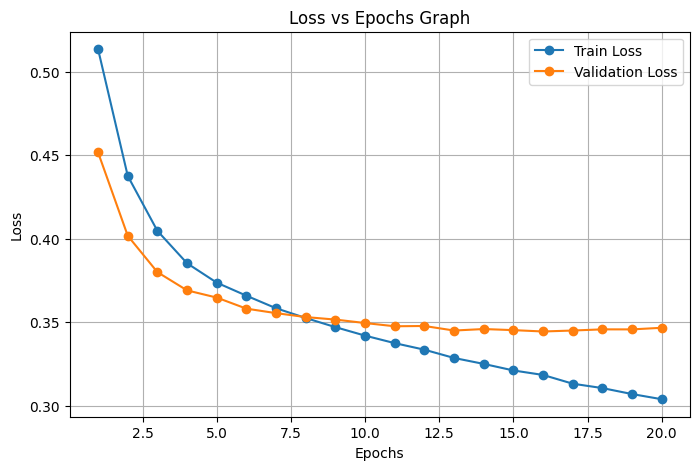

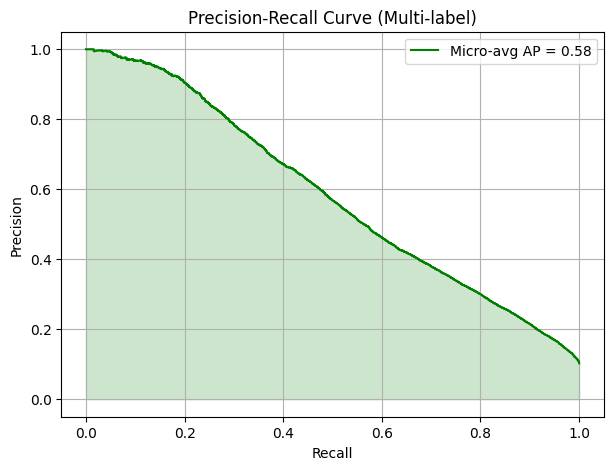

In [61]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()

    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_transformer_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)

In [62]:
import torch
import numpy as np
from sklearn.metrics import f1_score, classification_report, accuracy_score
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotion_list_28 = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity",
    "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief",
    "remorse", "sadness", "surprise"
]
num_classes = len(emotion_list_28)

def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                input_ids, _, labels = [b.to(device) for b in batch]
            elif len(batch) == 2:
                input_ids, labels = [b.to(device) for b in batch]
            else:
                raise ValueError("Unexpected batch format")

            if isinstance(model, GoEmotionTransformer):
                logits = model(input_ids)
            else:
                logits = model(input_ids)

            preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

model_classes = {
    "Bi-LSTM": GoEmotionLSTM,
    "Seq2Seq": GoEmotionSeq2Seq,
    "Transformer": GoEmotionTransformer
}

model_files = {
    "Bi-LSTM": "best_lstm_goemotion.pt",
    "Seq2Seq": "best_seq2seq_goemotion.pt",
    "Transformer": "best_transformer_goemotion.pt"
}

final_results = {}

for name, file_path in model_files.items():
    print(f"{'Model':<15} | {'Accuracy':<10} | {'Macro F1':<10}")
    try:
        if name == "Transformer":
            model = model_classes[name](
                vocab_size=30522,
                embed_dim=128,
                n_heads=8,
                n_layers=3,
                output_dim=num_classes,
                max_len=64
            ).to(device)
        else: 
            model = model_classes[name](
                vocab_size=30522,
                embedding_dim=128,
                hidden_dim=256,
                output_dim=num_classes
            ).to(device)

        model.load_state_dict(torch.load(file_path, map_location=device))
        model.eval()

        y_pred, y_true = get_predictions(model, test_loader, device)

        macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        accuracy = np.mean(np.all(y_pred == y_true, axis=1))

        report = classification_report(y_true, y_pred, target_names=emotion_list_28, zero_division=0)

        final_results[name] = {
            "accuracy": accuracy,
            "f1": macro_f1,
            "report": report
        }
        
        print(f"{name:<15} | {accuracy:<10.4f} | {macro_f1:<10.4f}")
        print(f"\nClassification Report for {name}:\n")
        print(report)

    except Exception as e:
        print(f"Error evaluating {name}: {e}")


Model           | Accuracy   | Macro F1  
Bi-LSTM         | 0.1085     | 0.4009    

Classification Report for Bi-LSTM:

                precision    recall  f1-score   support

    admiration       0.67      0.67      0.67      1015
     amusement       0.91      0.66      0.77       498
         anger       0.42      0.61      0.49       449
     annoyance       0.41      0.66      0.51       735
      approval       0.40      0.35      0.37       900
        caring       0.43      0.35      0.38       313
     confusion       0.49      0.47      0.48       381
     curiosity       0.71      0.70      0.70       454
        desire       0.46      0.27      0.34       238
disappointment       0.33      0.33      0.33       495
   disapproval       0.42      0.52      0.47       576
       disgust       0.36      0.45      0.40       330
 embarrassment       0.00      0.00      0.00       160
    excitement       0.41      0.29      0.34       397
          fear       0.32      0.05   